<a href="https://colab.research.google.com/github/matt322/diffusionmodel/blob/main/diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam
import numpy as np
import math
import time
device = "cuda" if torch.cuda.is_available() else "cpu"


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Noise Scheduler

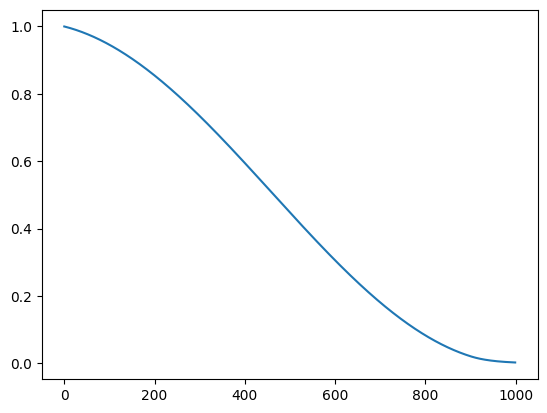

In [3]:
timesteps = 1000
s = 0.08
def f(t):
    return np.power(np.cos(((t / timesteps + s) / (1 + s)) * (np.pi / 2)), 2)
def beta(t):
    return min(1 - f(t) / f(t-1), 0.02)

noise_schedule = torch.tensor([beta(t) for t in range(timesteps)], device=device, dtype=torch.float)
#noise_schedule = torch.linspace(0.0001, 0.02, timesteps, device=device)
alphas = torch.cumprod(1 - noise_schedule, axis=0).to(device)
root_alphas = torch.sqrt(alphas).to(device)
root_alphas_dec = torch.sqrt(1 - alphas).to(device)
root_recip_alphas = 1 / torch.sqrt(1-noise_schedule).to(device)
post_var = noise_schedule * (1 - torch.nn.functional.pad(alphas[:-1], (1, 0), value=1.0)) / (1 - alphas).to(device)
plt.plot(alphas.to('cpu'))



def get_noise(x, t):
    noise = torch.randn_like(x)
    a = torch.index_select(root_alphas, 0, t).to(device)
    a = a[:, None, None, None]
    b = torch.index_select(root_alphas_dec, 0, t).to(device)
    b = b[:, None, None, None]
    return (a * x + b * noise).to(device), noise.to(device)

Dataset

In [ ]:
!unzip '/content/drive/MyDrive/Colab Notebooks/faces.zip'

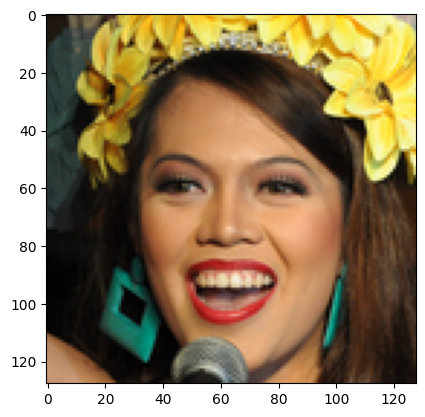

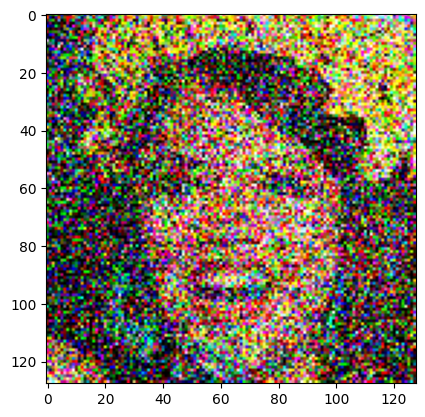

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Resize((64,64))
])
batch_size = 16
dataset = ImageFolder(root='faces', transform=transform)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

batch_images, batch_labels = next(iter(data_loader))
image = batch_images[0].to(device)
n = get_noise(image, torch.tensor([256], device=device))[0][0].to("cpu")
image_np = np.transpose(image.to("cpu").numpy(), (1, 2, 0))
n_np = np.transpose(n.numpy(), (1, 2, 0))

plt.imshow(image_np)
plt.show()
plt.imshow(n_np)
plt.show()

Network

In [6]:
class Block(nn.Module):
    def __init__(self, prev_chans, chans, down=True, use_trans = True, use_attn = False):
        super().__init__()
        self.time = Embedding(chans)
        self.c2 = nn.Conv2d(in_channels=chans, out_channels=chans, kernel_size=3, padding=1)
        self.silu = nn.SiLU()
        self.norm1 = nn.GroupNorm(32, chans)
        self.norm2 = nn.GroupNorm(32, chans)
        self.use_attn = use_attn
        self.use_trans = use_trans
        self.dropout = nn.Dropout(0.1)
        if use_attn:
            self.attn = Attention(chans)

        if down:
            self.trans = nn.Conv2d(chans, chans, 4, 2, 1)
            self.c1 = nn.Conv2d(in_channels=prev_chans, out_channels=chans, kernel_size=3, padding=1)
            if prev_chans != chans:
                self.shortcut = nn.Conv2d(prev_chans, chans, 1)
            else:
                self.shortcut = nn.Identity()
        else:
            self.trans = nn.ConvTranspose2d(chans, chans, 4, 2, 1)
            self.c1 = nn.Conv2d(in_channels=prev_chans*2, out_channels=chans, kernel_size=3, padding=1)
            if prev_chans*2 != chans:
                self.shortcut = nn.Conv2d(prev_chans*2, chans, 1)
            else:
                self.shortcut = nn.Identity()


    def forward(self, x, t, residual=None):
        if residual == None:
            h = self.dropout(self.norm1(self.silu(self.c1(x))))
        else:
            x = torch.cat((x, residual), dim=1)
            h = self.dropout(self.norm1(self.silu(self.c1(x))))
        t = self.time(t)
        h += t[..., None, None]
        h = self.norm2(self.dropout(self.silu(self.c2(h))))
        h += self.shortcut(x)
        if self.use_attn:
            h = self.attn(h)
        if self.use_trans:
            return self.trans(h), h
        return h, None

class Attention(nn.Module):
    def __init__(self, n_channels: int, n_heads: int = 4, d_k: int = None, n_groups: int = 32):
        super().__init__()
        if d_k is None:
            d_k = n_channels
        self.norm = nn.GroupNorm(n_groups, n_channels)
        self.projection = nn.Linear(n_channels, n_heads * d_k * 3)
        self.output = nn.Linear(n_heads * d_k, n_channels)
        self.scale = d_k ** -0.5
        self.n_heads = n_heads
        self.d_k = d_k

    def forward(self, x: torch.Tensor):
        batch_size, n_channels, height, width = x.shape
        x = x.view(batch_size, n_channels, -1).permute(0, 2, 1)
        qkv = self.projection(x).view(batch_size, -1, self.n_heads, 3 * self.d_k)
        q, k, v = torch.chunk(qkv, 3, dim=-1)
        attn = torch.einsum('bihd,bjhd->bijh', q, k) * self.scale
        attn = attn.softmax(dim=2)
        res = torch.einsum('bijh,bjhd->bihd', attn, v)
        res = res.reshape(batch_size, -1, self.n_heads * self.d_k)
        res = self.output(res)
        res += x
        res = res.permute(0, 2, 1).view(batch_size, n_channels, height, width)
        return res


class Embedding(nn.Module):
    def __init__(self, n_channels: int):
        super().__init__()
        self.n_channels = n_channels
        self.lin1 = nn.Linear(self.n_channels // 4, self.n_channels)
        self.silu = nn.SiLU()
        self.lin2 = nn.Linear(self.n_channels, self.n_channels)

    def forward(self, t: torch.Tensor):
        half_dim = self.n_channels // 8
        emb = math.log(10_000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=1)

        emb = self.silu(self.lin1(emb))
        emb = self.lin2(emb)

        return emb


class Unet(nn.Module):
    def __init__(self):
        super().__init__()
        c = 96
        down_channels = (c, c, 2*c, 2*c, 4*c, 4*c)
        up_channels = (4*c, 4*c, 2*c, 2*c, c, c)
        use_attn = (False, False, True, True)
        self.attn = Attention(8*c)
        self.downs = nn.ModuleList([
                                    Block(down_channels[0], down_channels[0], use_attn=use_attn[0], use_trans=False),
                                    Block(down_channels[0], down_channels[1], use_attn=use_attn[0]),
                                    Block(down_channels[1], down_channels[2], use_attn=use_attn[1], use_trans=False),
                                    Block(down_channels[2], down_channels[3], use_attn=use_attn[1]),
                                    Block(down_channels[3], down_channels[4], use_attn=use_attn[2], use_trans=False),
                                    Block(down_channels[4], down_channels[5], use_attn=use_attn[2])
                                    ])
        self.ups = nn.ModuleList([
                                    Block(up_channels[0], up_channels[1], use_attn=use_attn[2], use_trans=False, down=False),
                                    Block(up_channels[1]//2, up_channels[2], use_attn=use_attn[2], down=False),
                                    Block(up_channels[2], up_channels[3], use_attn=use_attn[1], use_trans=False, down=False),
                                    Block(up_channels[3]//2, up_channels[4], use_attn=use_attn[1], down=False),
                                    Block(up_channels[4], up_channels[5], use_attn=use_attn[0], use_trans=False, down=False),
                                    Block(up_channels[5]//2, up_channels[5], use_attn=use_attn[0], down=False, use_trans=False)
                                    ])
        self.output = nn.Conv2d(up_channels[-1], 3, 1)
        self.start = nn.Conv2d(3, c, 3, padding=1)
        self.embed = Embedding(32)
        self.middle = nn.ModuleList([
            Block(4*c, 8*c, use_attn=True, use_trans=False),
            Block(4*c, 4*c, use_attn=False, down=False)
        ])

    def forward(self, x, t):
        x = self.start(x)
        residuals = []
        for i,d in enumerate(self.downs):
            x = d(x, t)
            if i % 2 == 1:
                residuals.append(x[1])
            x = x[0]

        x = self.middle[0](x, t)[0]
        x = self.middle[1](x, t)[0]
        for i,d in enumerate(self.ups):
            if i % 2 == 0:
                x = d(x, t, residuals.pop())[0]
            else:
                x = d(x, t)[0]
        return self.output(x)





In [10]:
loss = nn.MSELoss()
model = Unet()
model.to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/diffusion_model_25-1-1000'))
print("Num params: ", sum(p.numel() for p in model.parameters()))
model(torch.randn((16, 3, 64, 64), device=device), torch.randn((16), device=device)).shape

Num params:  76190211


torch.Size([16, 3, 64, 64])

Sample

In [8]:
@torch.no_grad()
def sample(x, t):
    mean = root_recip_alphas[t] * (x - noise_schedule[t] * model(x, t) / root_alphas_dec[t])
    if t == 0:
        return mean
    noise = torch.randn_like(x)
    return mean + torch.sqrt(post_var[t]) * noise

def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)),
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.to("cpu").numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    if len(image.shape) == 4:
        image = image[0, :, :, :]
    plt.imshow(reverse_transforms(image))

@torch.no_grad()
def plot_image():
    img = torch.randn((1, 3, 128, 128), device = device)
    plt.figure(figsize=(20,20))
    step = int(timesteps/10)
    model.eval()
    for i in range(0, timesteps)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample(img, t)
        if i % step == 0:
            plt.subplot(1, 10, int(i/step)+1)
            show_tensor_image(img)
    plt.show()

@torch.no_grad()
def plot_image_full():
    img = torch.randn((1, 3, 128, 128), device = device)
    model.eval()
    for i in range(0, timesteps)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample(img, t)
    show_tensor_image(img)
    plt.show()

#plot_image()


Training

In [ ]:
optimizer = Adam(model.parameters(), lr = 2e-5)
epochs = 4
model.train()


for epoch in range(epochs):
    l = 0
    for step, batch in enumerate(data_loader):
        optimizer.zero_grad()
        t = torch.randint(0, timesteps, (batch_size,), device=device)
        x_noise, noise = get_noise(batch[0].to(device), t)
        pred = model(x_noise, t)
        output = loss(noise, pred)
        output.backward()
        optimizer.step()
        l += output.item()
        if step % 50 == 0:
            print("Epoch {}, step {}, loss {}".format(epoch, step, l/50))
            l = 0
        if step % 300 == 0:
            plot_image_full()
            model.train()
        if step % 1000 == 0:
            torch.save(model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/diffusion_model_25-{}-{}".format(epoch, step))





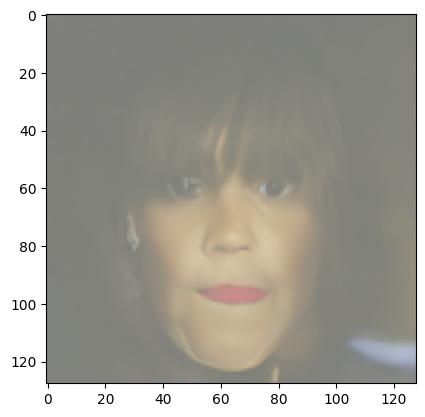

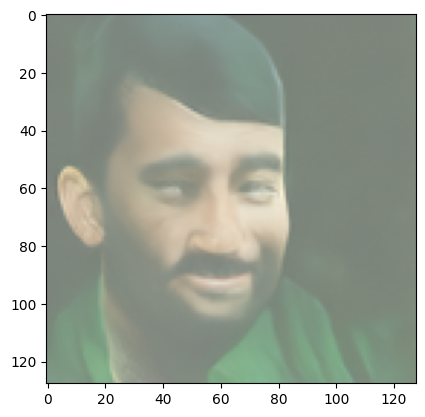

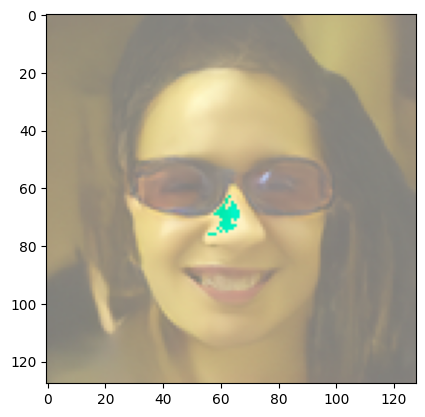

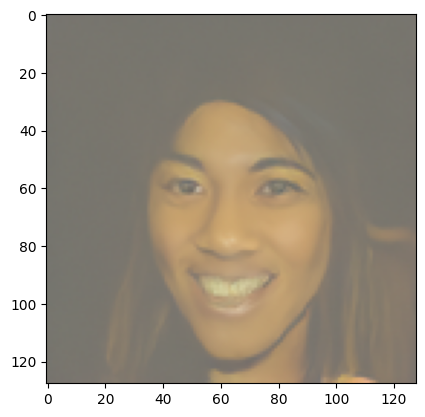

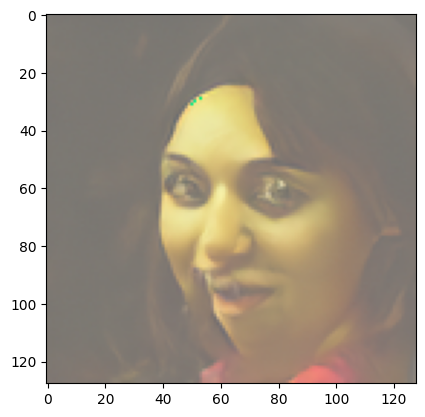

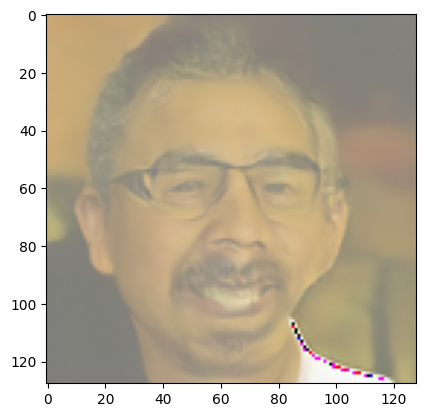

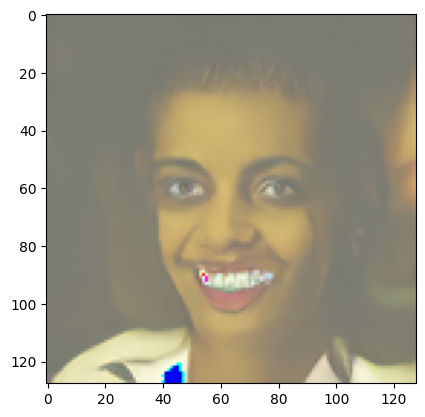

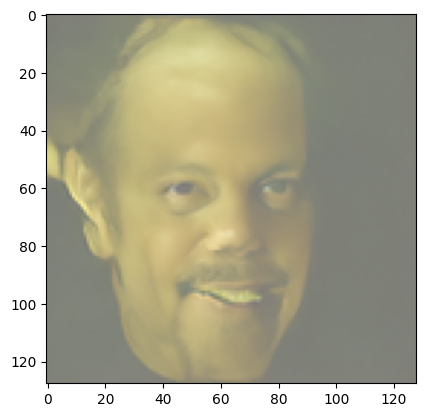

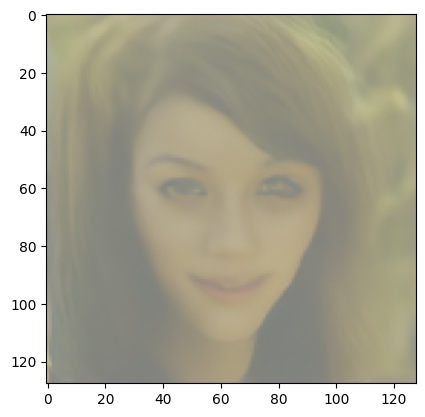

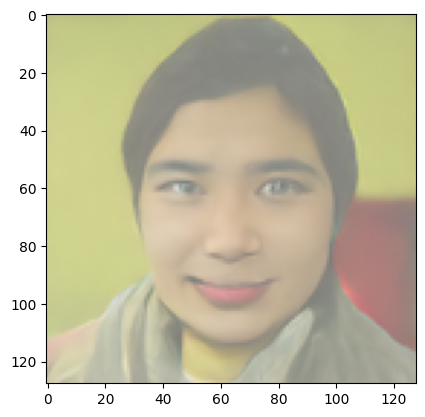

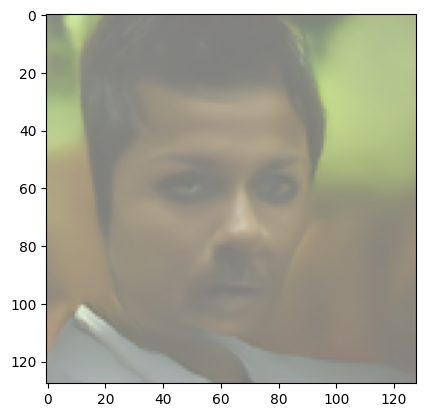

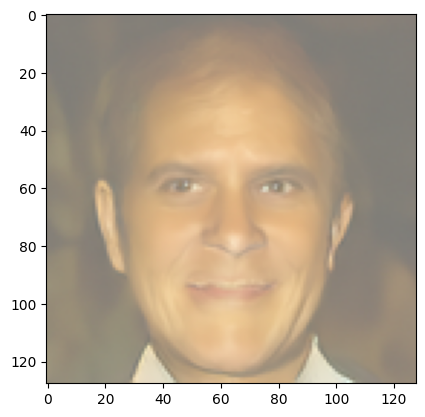

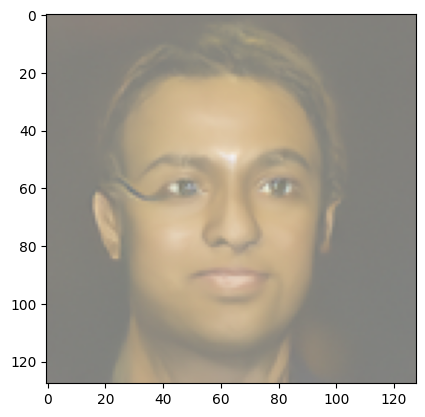

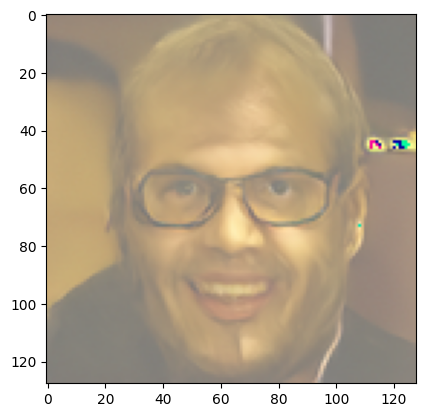

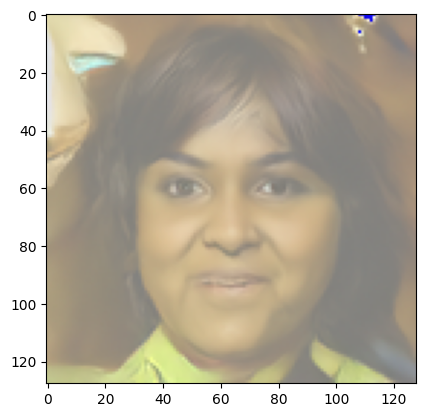

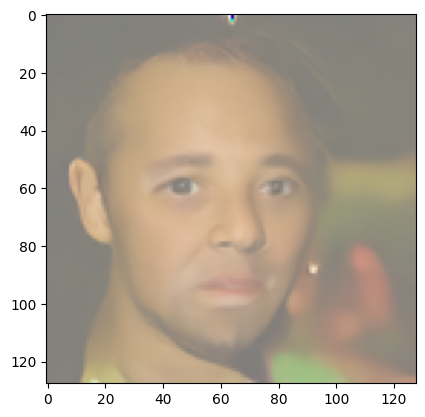

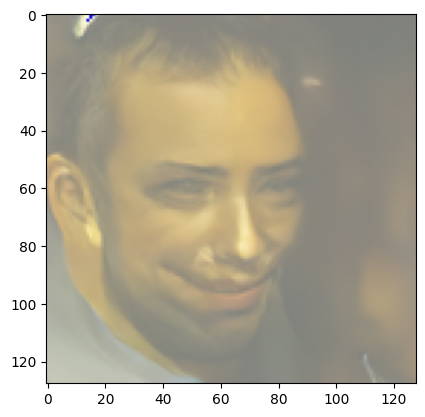

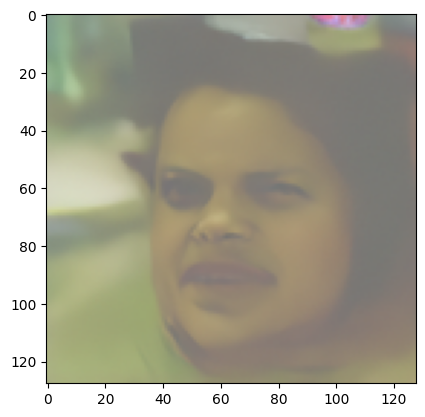

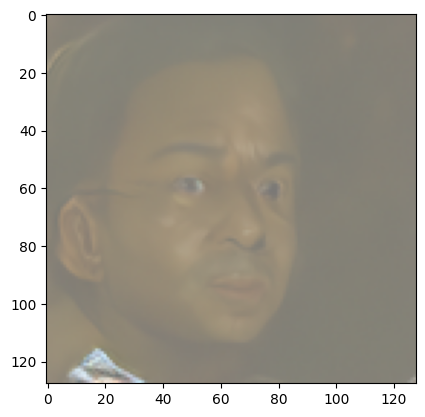

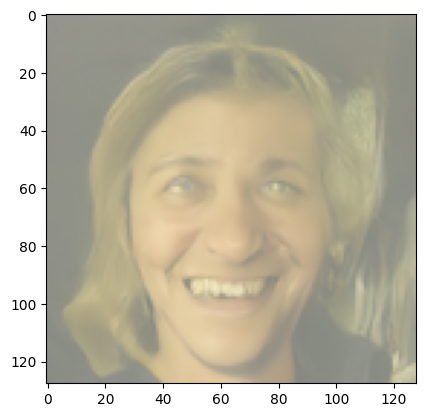

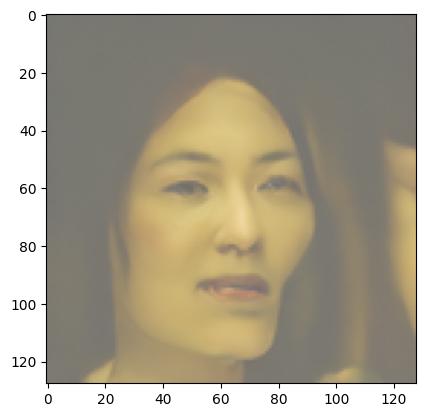

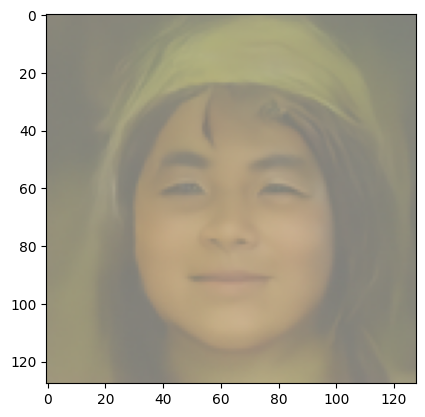

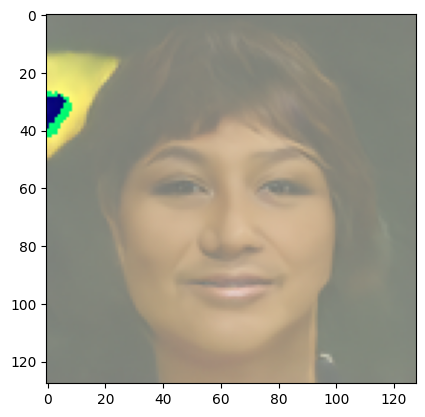

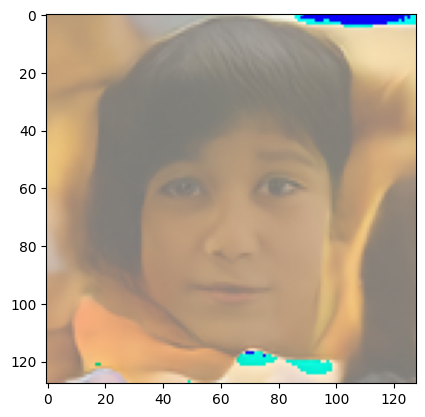

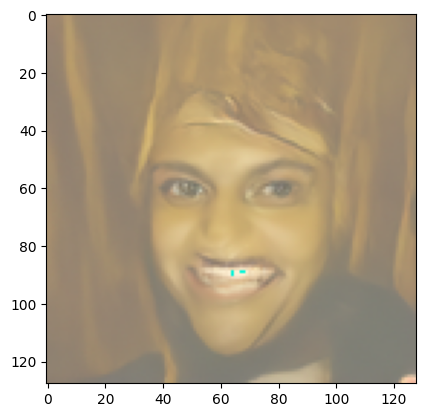

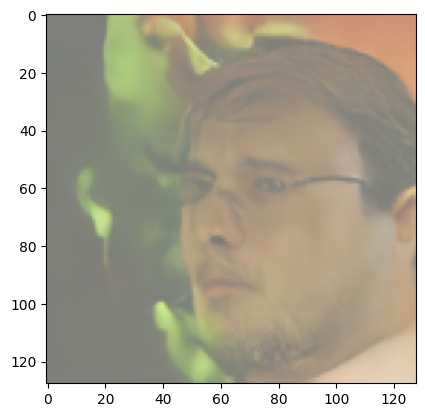

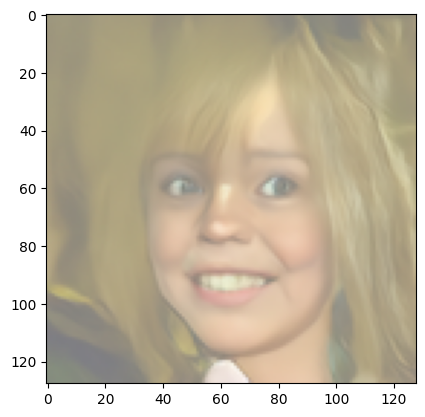

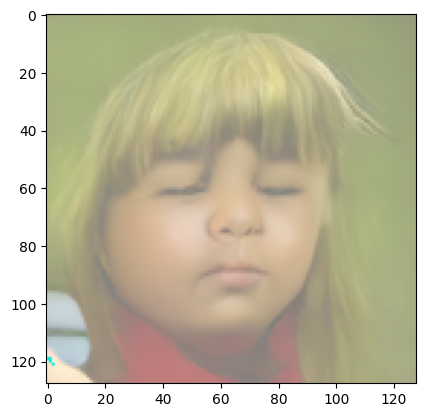

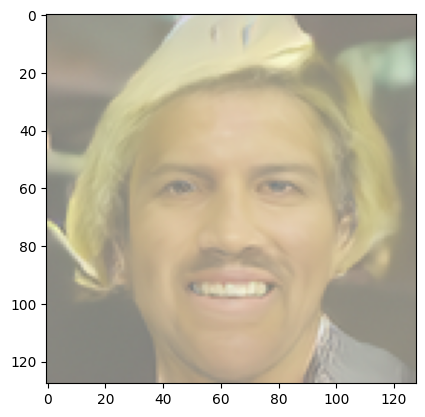

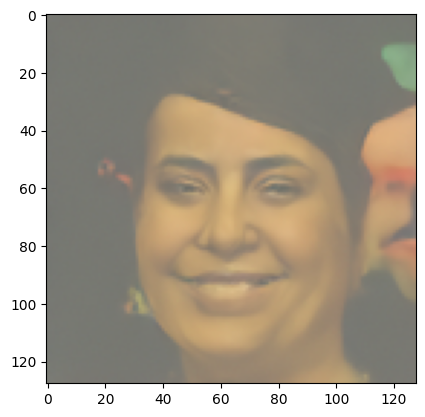

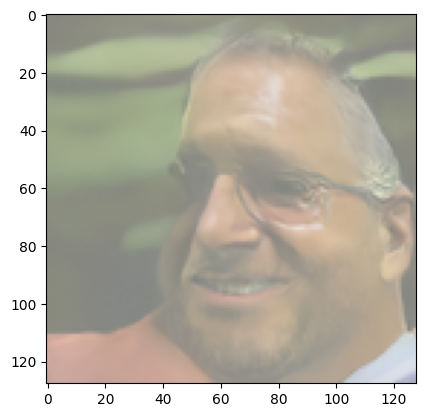

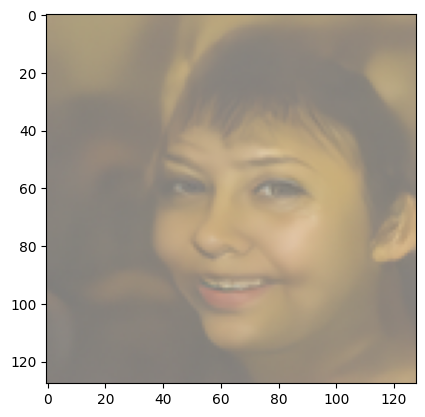

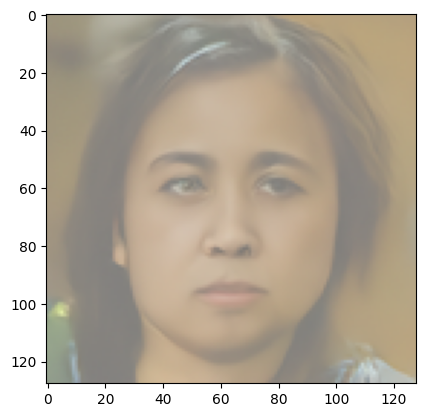

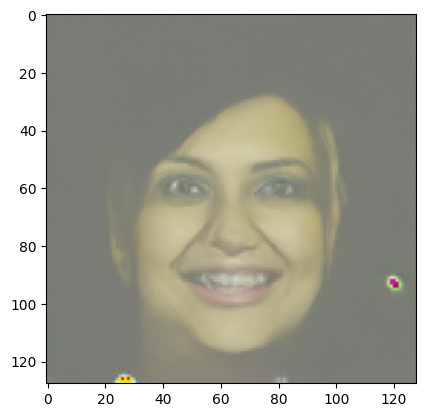

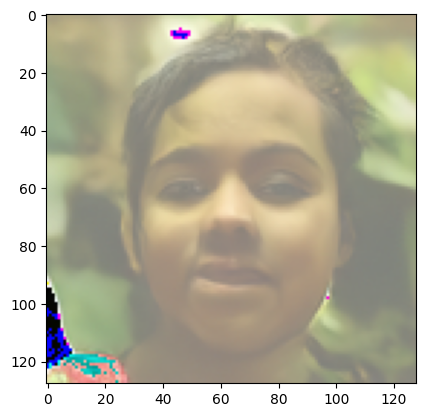

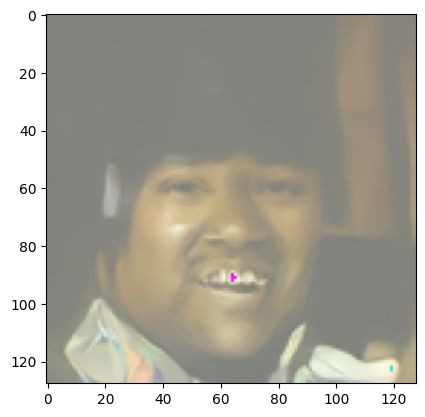

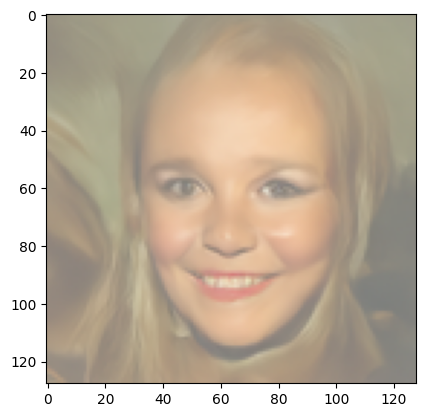

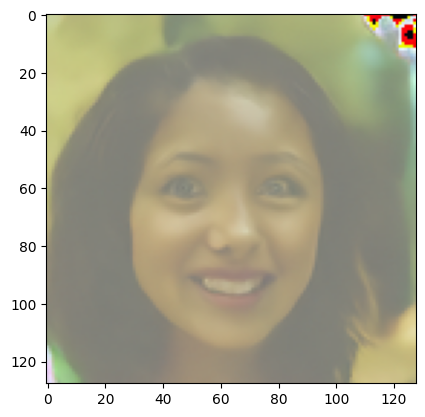

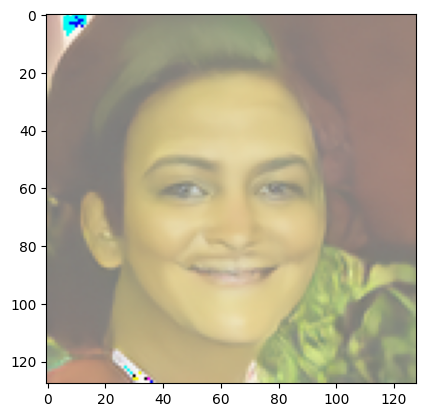

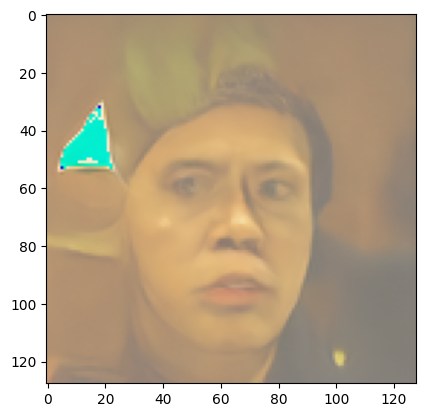

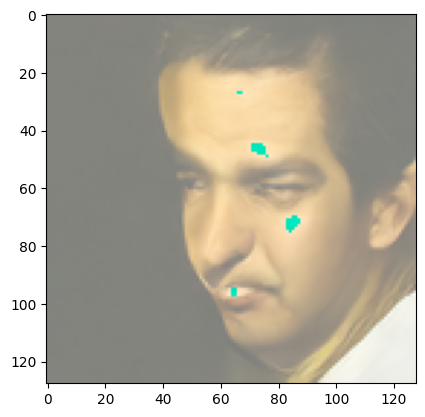

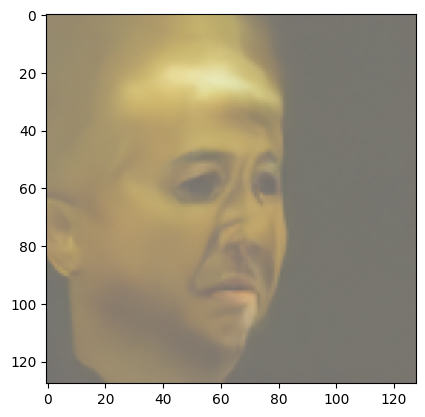

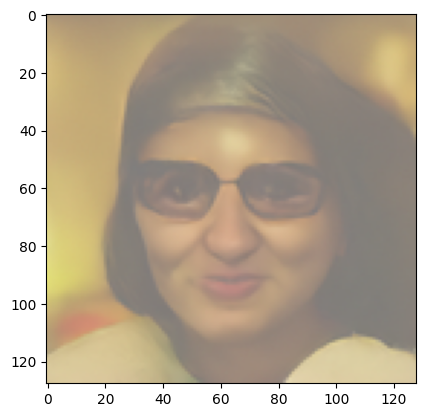

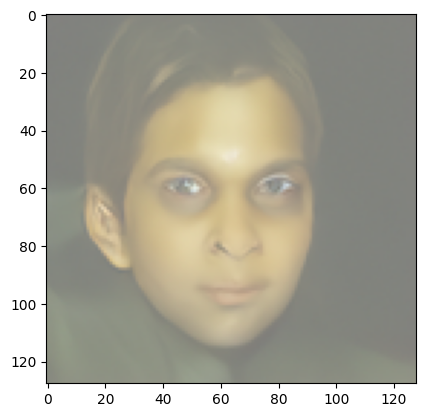

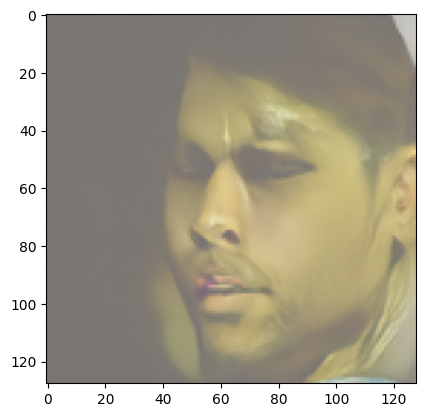

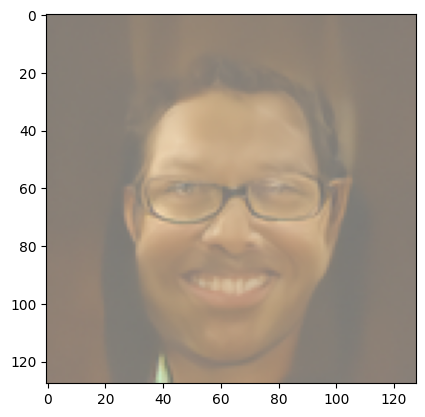

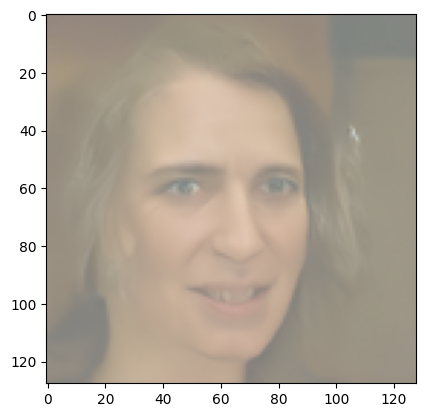

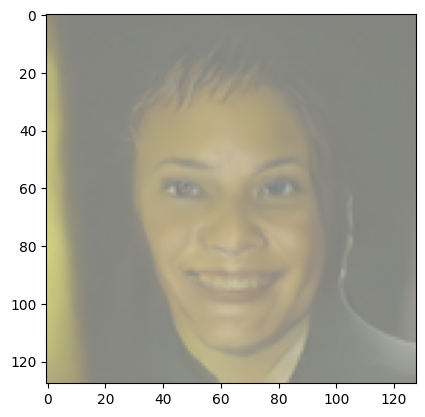

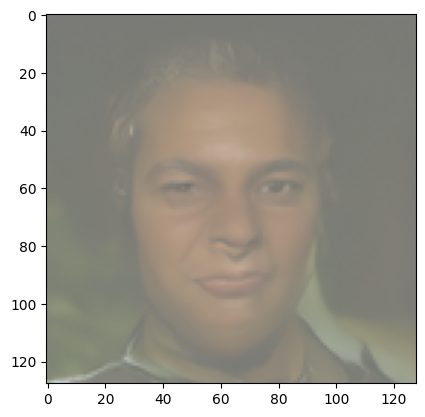

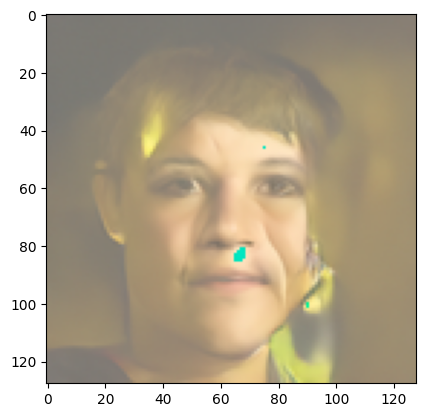

In [11]:
for _ in range(50):
    plot_image_full()